Commands to install astropy and sep if they are not installed

In [33]:
!pip install astropy
!pip install sep

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Imports and setting up the plot

In [34]:
import numpy as np
import sep
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [10.,8.]


Reading in the image


In [35]:
#changed to hdu bc buffer was to small lol
temp = fits.open('hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits')
data = temp[0].data

Plotting the data

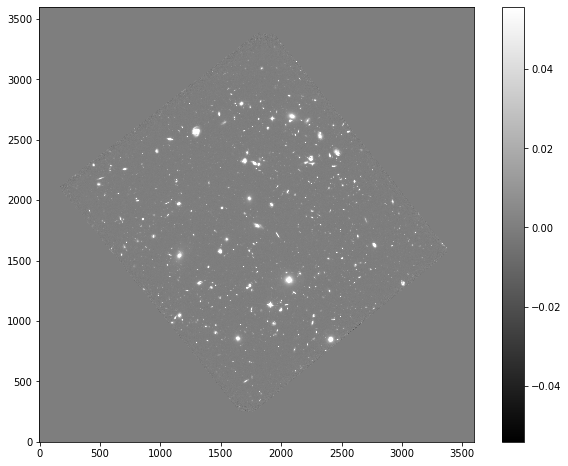

In [36]:
mean = np.mean(data)
std = np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=mean-std, vmax=mean+std, origin='lower')
plt.colorbar();
plt.savefig('udf_fits_image.png')

Background Subtraction then plotting said background

In [37]:
#added line because compiler said byte order was wrong
data = data.byteswap().newbyteorder()
bkg = sep.Background(data)

Global mean and noise from background respectivly

In [38]:
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


Turn bkg into a numpy 2d array

In [39]:
bkg_image = bkg.back()

Plot it 

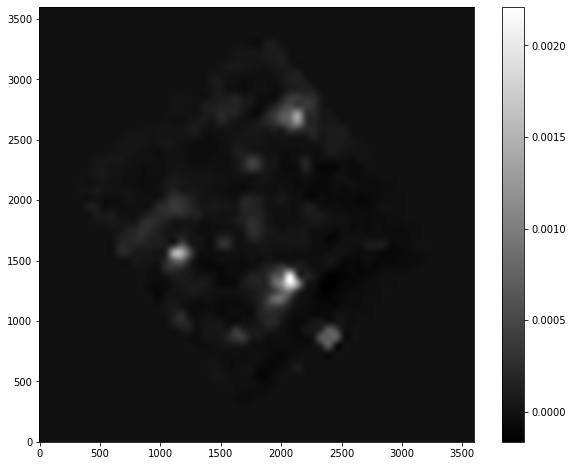

In [40]:
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig('udf_fits_background.png')

Calculate background noise then plot it 

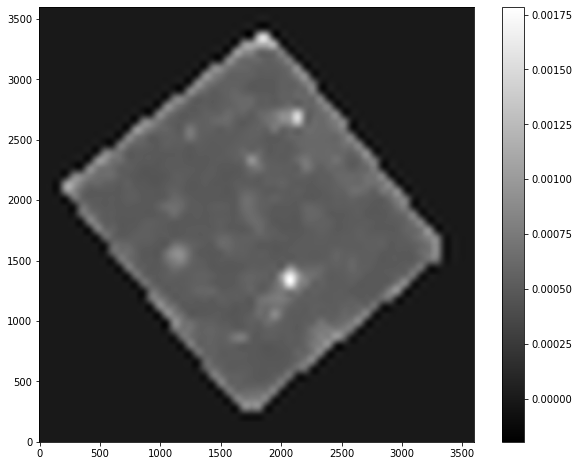

In [41]:
# gives 2d numpy array
bkg_rms = bkg.rms()
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig('udf_fits_background_noise.png')

Subtract the background from the data

In [42]:
data_sub = data - bkg

# Run object detection

the print num of objects detected



In [43]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)
len(objects)

8643

Now plot and circle the objects detected

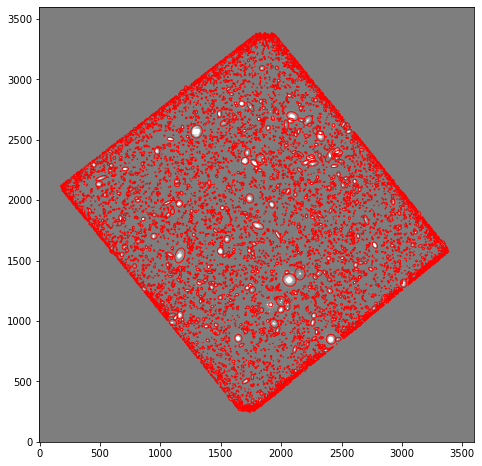

In [44]:

from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
plt.savefig('udf_fits_object_ellipses.png')

Object Fields

In [45]:
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

Performing Aperture Photometry

In [46]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

In [47]:
# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.031282 +/- 0.176890
object 1: flux = 0.031018 +/- 0.176142
object 2: flux = -0.024388 +/- 0.002883
object 3: flux = 0.001947 +/- 0.044219
object 4: flux = 0.012457 +/- 0.111649
object 5: flux = -0.011228 +/- 0.002875
object 6: flux = 0.029368 +/- 0.171394
object 7: flux = -0.009126 +/- 0.002875
object 8: flux = 0.048023 +/- 0.219161
object 9: flux = 0.027840 +/- 0.166877


Histogram Fluxes

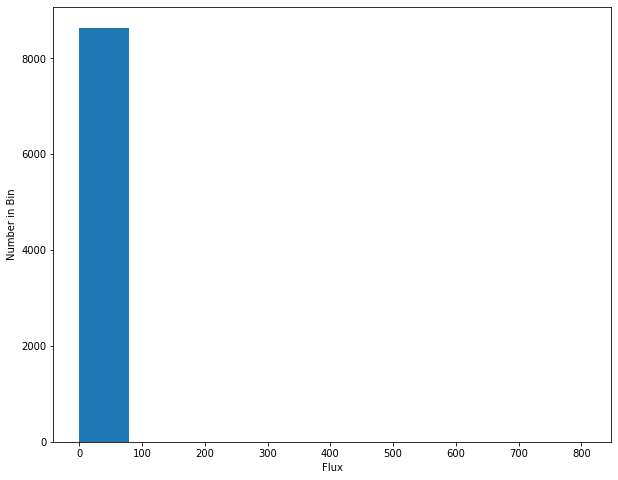

In [48]:
plt.hist(flux)
plt.xlabel('Flux')
plt.ylabel('Number in Bin')
plt.savefig('udf_fit_flux_hist.png')

Mean meadian and std of the distribution of fluxes

In [49]:
print('Mean = ', np.mean(flux))
print('Median = ', np.median(flux))
print('Standard Deviation = ', np.std(flux))

Mean =  0.3617466258281149
Median =  0.030954822942148894
Standard Deviation =  9.241925555851745


Find largest outlier

In [50]:
outlier = 0
outlier_std = 0
outlier_cord_X = None
outlier_cord_Y = None
mean = np.mean(flux)
median = np.median(flux)
std = np.std(flux)

for i in range(len(flux)):
  temp = (flux[i] - mean)/std
  if temp > outlier:
    outlier = flux[i]
    outlier_std = temp
    outlier_cord_X = objects['a'][i]
    outlier_cord_Y = objects['b'][i]

print('Largest Outlier = ', outlier)
print('Num Stds it is from Mean = ', outlier_std)
print('Largest Outliers Cordinates = (', outlier_cord_X, ', ', outlier_cord_Y, ')')


Largest Outlier =  807.2972835731507
Num Stds it is from Mean =  87.31249046216263
Largest Outliers Cordinates = ( 5.6294145584106445 ,  5.472214698791504 )


# 3 Color Images
Methods for rescale and quick look from lecture 18

In [51]:
def rescale_image(data):
    pdata_tmp = data.copy()
    m = np.nanmean(pdata_tmp)
    vplmin = m/2.
    vpmin = np.log10(vplmin)
    vpmax = np.log10(m*100)
    pdata_tmp[pdata_tmp<vplmin] = vplmin
    pdata_tmp = np.log10(pdata_tmp)
    return pdata_tmp,vpmin,vpmax
    
def fits_quicklook(data,fnx=10,fny=10):
    f = plt.figure(figsize=(fnx,fny))
    pdata_tmp,vpmin,vpmax = rescale_image(data)
    plt.imshow(pdata_tmp,vmin=vpmin,vmax=vpmax)

Load in Data and look at the data

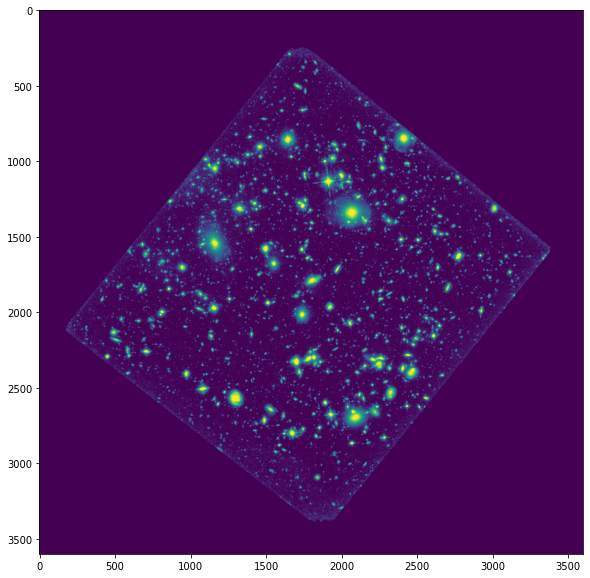

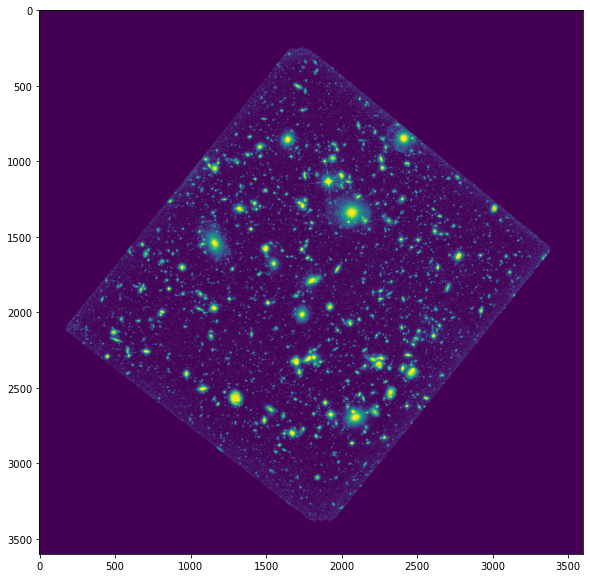

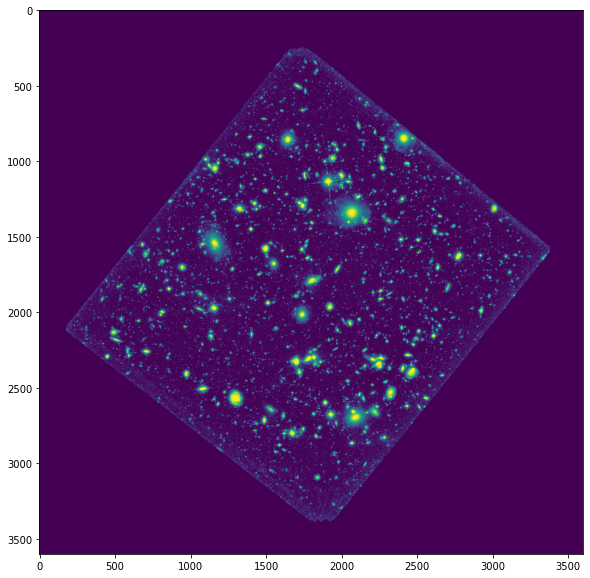

In [52]:
fits1 = 'hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits'
fits2 = 'hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits'
fits3 = 'hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits'

hdu1 = fits.open(fits1)
hdu2 = fits.open(fits2)
hdu3 = fits.open(fits3)

data1 = hdu1[0].data
data2 = hdu2[0].data
data3 = hdu3[0].data

fits_quicklook(data1)
fits_quicklook(data2)
fits_quicklook(data3)

# Make 3-coloar Image from data

In [53]:
data_1res, d1min, d1max = rescale_image(data1)
data_2res, d2min, d2max = rescale_image(data2)
data_3res, d3min, d3max = rescale_image(data3)

Limit the Data between max and min

In [54]:
data_1res[data_1res<d1min] = d1min
data_1res[data_1res>d1max] = d1max
data_2res[data_2res<d2min] = d2min
data_2res[data_2res>d2max] = d2max
data_3res[data_3res<d3min] = d3min
data_3res[data_3res>d3max] = d3max

Create the RGB Image and plot and save it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


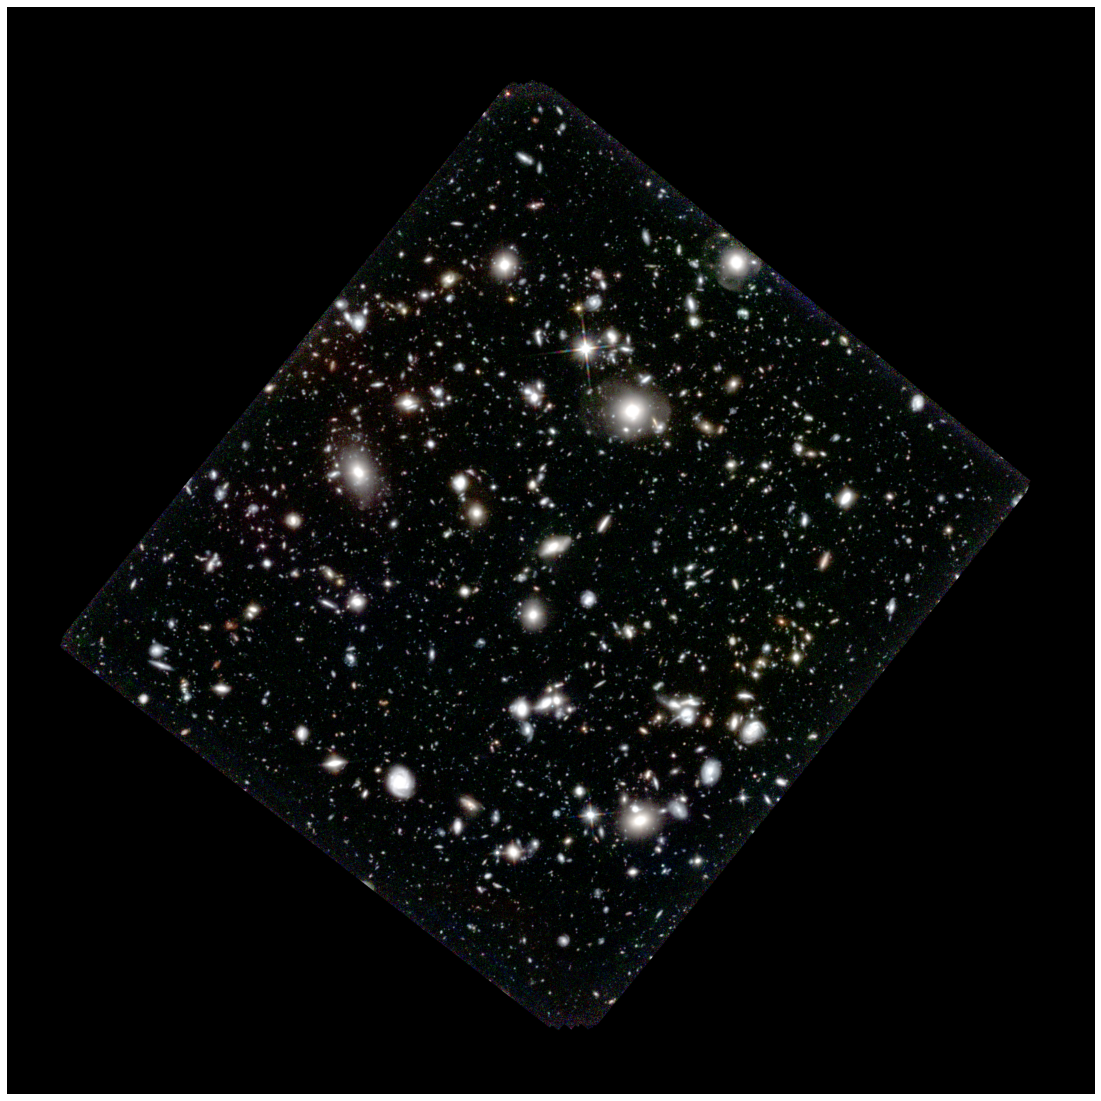

In [55]:
rgb = np.zeros((data_1res.shape[0], data_1res.shape[1],3))
rgb[:,:,0] = (data_1res-d1min)/(d1max-d1min)
rgb[:,:,1] = (data_2res-d2min)/(d2max-d2min)
rgb[:,:,2] = (data_3res-d3min)/(d3max-d3min)
f,ax = plt.subplots(1,1,figsize=(20,20))
ax.axis('off')
ax.imshow(rgb)
plt.savefig('udf_rgb_image.png')